### Q1. Derivative of the loss function for an autoencoder for binary inputs

 $ L(f(x)) = - \Sigma_k  x_k log \hat{x_k} + (1-x_k)log(1-\hat{x_k}) $

 $ s_k = \Sigma_j h_k w_{jk} $
  
### $\frac{\delta L}{\delta w_{jk}} = \frac{\delta{L}}{\delta{\hat{x_k}}}\frac{\delta{\hat{x_k}}}{\delta{s_k}}\frac{\delta{s_k}}{\delta{w_{jk}}} $

### $\frac{\delta L}{\delta \hat{x_k}} = -\frac{x_k}{\hat{x_k}} + \frac{1-x_k}{1-\hat{x_k}}$

### $ = \frac{\hat{x_k} - x_k}{\hat{x_k}(1-\hat{x_k})}$

Since the activation function is sigmoid, 

### $ \frac{\delta{\hat{x_k}}}{\delta{s_k}} = \hat{x_k}(1-\hat{x_k}) $

### $\frac{\delta{s_k}}{w_{jk}} = h_j$

Therefore,
 
### $\frac{\delta{L}}{\delta{s_k}} = \hat{x_k} - x_k$ 

and,

### $\frac{\delta L}{\delta w_{jk}} =  (\hat{x_k} - x_k)h_j$


### Q2.

In [4]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [19]:
def get_data():
    """
    Returns first 100 examples from each category of mnist and their corresponding labels
    """
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    train_data = np.zeros((1000, 28*28))
    labels = np.zeros((1000, 10))
    example = 0
    for digit in range(10):
        count = 100
        for i, label in enumerate(mnist.train.labels):
            if label[digit]:
                labels[example, :] = label[:]
                train_data[example, :] = mnist.train.images[i] 
                count -=1
                example+=1
            if count == 0:
                break
    data = np.concatenate((train_data, labels), axis=1)
    np.random.shuffle(data)
    train_data, labels = data[:, 0:784], data[:,784:]
    return train_data, labels


# utility functions to create weight variables
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [68]:
train_data, labels = get_data()
actual_labels = np.argmax(labels, axis=1)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [69]:
def get_next_batch(train_data, minibatch_size=50):
    i = 0
    yield train_data[i:i+minibatch_size, :]
    i+=minibatch_size
    print(i)
    if i > train_data.shape[0]:
        i=0

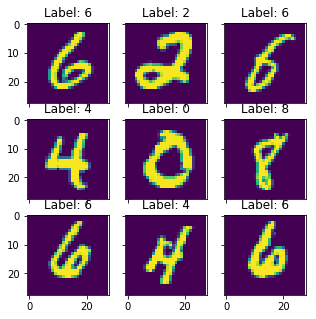

In [70]:
# Visualize a few images from the training data
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(5,5))
k=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(np.reshape(train_data[k], (28, 28)))
        axs[i,j].set_title('Label: {}'.format(np.argmax(labels[k])))
        k+=1

plt.show()

In [71]:
class Model(object):
    def __init__(self, N=2):
        
        # define place holders for input and output
        # Note that for autoencoders input and output are the same 
        self.X = tf.placeholder(tf.float32, shape=[None, 28*28])

        self.W_ih = weight_variable([28*28, N])
        self.b_ih = bias_variable([N])

        self.latent = tf.nn.sigmoid(tf.matmul(self.X, self.W_ih) + self.b_ih)

        self.W_ho = weight_variable([N, 28*28])
        self.b_ho = weight_variable([28*28])

        self.reconstruction = tf.sigmoid(tf.matmul(self.latent, self.W_ho) + self.b_ho)

        self.loss = tf.reduce_mean(tf.squared_difference(self.reconstruction, self.X))
#         self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.reconstruction, labels=self.X))
        self.train_step = tf.train.AdamOptimizer(1e-3).minimize(self.loss)
    
    def get_latent_representation(self, ip):
        return tf.nn.sigmoid(tf.matmul(ip, self.W_ih) + self.b_ih)
    
    
    def get_reconstruction(self, latent):
        return tf.nn.sigmoid(tf.matmul(tf.cast(latent, tf.float32), self.W_ho) + self.b_ho)
    
    def get_latent_space(self):
        return self.latent

In [190]:
def get_precision_recall(rep, rep_label, space, limit=50):
    """
    Args:
        rep: Representation of the candidate
        rep_label: A single digit indicating the number `rep` represents
    """
    distances = np.sqrt(np.sum((space - rep)*(space-rep), axis=1))
    dist_labels = np.concatenate((np.reshape(distances, (distances.shape[0], 1)), np.reshape(actual_labels, (actual_labels.shape[0], 1))), axis=1)
    sorted_distances = np.sort(dist_labels)
    
    sorted_distances = sorted_distances[:50, :]
    precision = np.count_nonzero(sorted_distances[:,1].astype(int)==rep_label)
    return precision
    

In [99]:
model_2 = Model(2)
model_5 = Model(5)
model_10 = Model(10)

In [100]:
def train_model(model, N=2, epochs=1000):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            model.train_step.run(feed_dict={model.X: train_data})
            if epoch%100==0:
                reconstruction_loss = model.loss.eval(feed_dict={model.X: train_data})
                biases = model.latent.eval(feed_dict={model.X:train_data})
                print('step %d, Reconstruction loss %g' % (epoch, reconstruction_loss))

        ex = tf.placeholder(tf.float32, shape=[None, 28*28])
        latent_representation = model.get_latent_representation(ex)
        hidden = latent_representation.eval(feed_dict={ex: np.reshape(train_data, (1000, 784))})

        latent = tf.placeholder(tf.float32, shape=[None, N])
        reconstructed_output = model.get_reconstruction(latent)
        reconstruction = reconstructed_output.eval(feed_dict={latent: hidden})
        latent_space = model.get_latent_space()
        space = latent_space.eval(feed_dict={model.X: train_data})
        
#         recall = get_precision_recall(hidden, actual_labels[0], space, limit=50)
        
    return reconstruction_loss, hidden, reconstruction 

In [101]:
reconstruction_loss_2, latent_rep2, reconstruction2 = train_model(model_2)
reconstruction_loss_5, latent_rep5, reconstruction5  = train_model(model_5, N=5)
reconstruction_loss_10, latent_rep10, reconstruction10 = train_model(model_10, N=10)

step 0, Reconstruction loss 0.230636
step 100, Reconstruction loss 0.0880986
step 200, Reconstruction loss 0.0724115
step 300, Reconstruction loss 0.0688463
step 400, Reconstruction loss 0.0663252
step 500, Reconstruction loss 0.0648557
step 600, Reconstruction loss 0.0639
step 700, Reconstruction loss 0.0631816
step 800, Reconstruction loss 0.0625834
step 900, Reconstruction loss 0.0620387
step 0, Reconstruction loss 0.231083
step 100, Reconstruction loss 0.0739413
step 200, Reconstruction loss 0.0644525
step 300, Reconstruction loss 0.0567987
step 400, Reconstruction loss 0.0523902
step 500, Reconstruction loss 0.0496213
step 600, Reconstruction loss 0.0480483
step 700, Reconstruction loss 0.0470388
step 800, Reconstruction loss 0.0462768
step 900, Reconstruction loss 0.0457035
step 0, Reconstruction loss 0.230407
step 100, Reconstruction loss 0.0685018
step 200, Reconstruction loss 0.0545552
step 300, Reconstruction loss 0.0463816
step 400, Reconstruction loss 0.0415511
step 500, Re

In [172]:
precision2 = get_precision_recall(latent_rep2[0], actual_labels[0], latent_rep2, limit=50)
precision5 = get_precision_recall(latent_rep5[0], actual_labels[0], latent_rep5, limit=50)
precision10 = get_precision_recall(latent_rep10[0], actual_labels[0], latent_rep10, limit=50)
print(precision2, precision5, precision10)

11 6 3


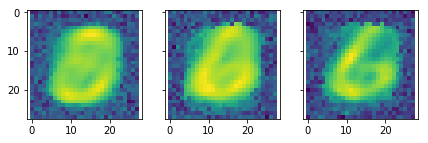

In [106]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7,2))
axs[0].imshow(np.reshape(reconstruction2[0], (28, 28)))
axs[1].imshow(np.reshape(reconstruction5[0], (28, 28)))
axs[2].imshow(np.reshape(reconstruction10[0], (28, 28)))
plt.show()

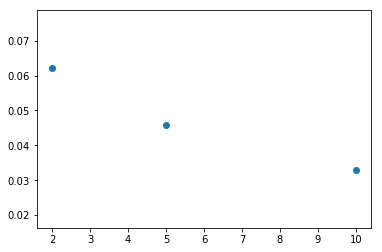

In [107]:
plt.scatter([2,5,10], [reconstruction_loss_2, reconstruction_loss_5, reconstruction_loss_10])
plt.show()

In [188]:
# Average precision for each digit. Recall is always 1.
# N = 2
print('##N=2###')
precision_ae=[]
for i in range(10): # digit
    precision = 0
    for j in range(train_data.shape[0]):
        if actual_labels[j] == i:
            precision += get_precision_recall(latent_rep2[j], actual_labels[j], latent_rep2, limit=50)
    precision_ae.append(precision/50)
    print('Average precision in top 50 for the digit {}: {}'.format(i, precision/50))
    
print('##N=5###')
for i in range(10): # digit
    precision = 0
    for j in range(train_data.shape[0]):
        if actual_labels[j] == i:
            precision += get_precision_recall(latent_rep5[j], actual_labels[j], latent_rep5, limit=50)
    print('Average precision in top 50 for the digit {}: {}'.format(i, precision/50))

print('###N=10###')
for i in range(10): # digit
    precision = 0
    for j in range(train_data.shape[0]):
        if actual_labels[j] == i:
            precision += get_precision_recall(latent_rep10[j], actual_labels[j], latent_rep10, limit=50)
    print('Average precision in top 50 for the digit {}: {}'.format(i, precision/50))


##N=2###
Average precision in top 50 for the digit 0: 0.36
Average precision in top 50 for the digit 1: 2.86
Average precision in top 50 for the digit 2: 2.12
Average precision in top 50 for the digit 3: 4.36
Average precision in top 50 for the digit 4: 9.4
Average precision in top 50 for the digit 5: 7.12
Average precision in top 50 for the digit 6: 18.86
Average precision in top 50 for the digit 7: 9.44
Average precision in top 50 for the digit 8: 9.24
Average precision in top 50 for the digit 9: 13.12
##N=5###
Average precision in top 50 for the digit 0: 0.12
Average precision in top 50 for the digit 1: 0.44
Average precision in top 50 for the digit 2: 0.06
Average precision in top 50 for the digit 3: 0.26
Average precision in top 50 for the digit 4: 1.34
Average precision in top 50 for the digit 5: 1.76
Average precision in top 50 for the digit 6: 5.7
Average precision in top 50 for the digit 7: 2.72
Average precision in top 50 for the digit 8: 3.64
Average precision in top 50 for 

In [ ]:
# PCA method

In [112]:
from sklearn.decomposition import PCA

In [113]:
def PCA_N(N=2):
    pca = PCA(n_components=N)
    pca.fit(train_data.transpose())
    return pca.components_

In [174]:
pca_2_components = PCA_N(N=2)
precision2 = get_precision_recall(pca_2_components[:, 0], actual_labels[0], pca_2_components.transpose())
pca_5_components = PCA_N(N=5)
precision5 = get_precision_recall(pca_5_components[:, 0], actual_labels[0], pca_5_components.transpose())
pca_10_components = PCA_N(N=10)
precision10 = get_precision_recall(pca_10_components[:, 0], actual_labels[0], pca_10_components.transpose())

In [175]:
print(precision2, precision5, precision10)

12 12 12


In [186]:
print('#####Using PCA####')
# Average precision for each digit. Recall is 1.
# N = 2
precision_pca=[]
print('###N=2###')
for i in range(10): # digit
    precision = 0
    for j in range(train_data.shape[0]):
        if actual_labels[j] == i:
            precision += get_precision_recall(pca_2_components[:, j], actual_labels[j], pca_2_components.transpose(), limit=50)
    precision_pca.append(precision/50)
    print('Average precision in top 50 for the digit {}: {}'.format(i, precision/50))
    
print('###N=5###')
for i in range(10): # digit
    precision = 0
    for j in range(train_data.shape[0]):
        if actual_labels[j] == i:
            precision += get_precision_recall(pca_5_components[:, j], actual_labels[j], pca_5_components.transpose(), limit=50)
    print('Average precision in top 50 for the digit {}: {}'.format(i, precision/50))

print('###N=10###')
for i in range(10): # digit
    precision = 0
    for j in range(train_data.shape[0]):
        if actual_labels[j] == i:
            precision += get_precision_recall(pca_10_components[:, j], actual_labels[j], pca_10_components.transpose(), limit=50)
    print('Average precision in top 50 for the digit {}: {}'.format(i, precision/50))


#####Using PCA####
###N=2###
Average precision in top 50 for the digit 0: 12.0
Average precision in top 50 for the digit 1: 10.0
Average precision in top 50 for the digit 2: 4.0
Average precision in top 50 for the digit 3: 10.0
Average precision in top 50 for the digit 4: 14.0
Average precision in top 50 for the digit 5: 6.0
Average precision in top 50 for the digit 6: 24.0
Average precision in top 50 for the digit 7: 4.0
Average precision in top 50 for the digit 8: 6.0
Average precision in top 50 for the digit 9: 10.0
###N=5###
Average precision in top 50 for the digit 0: 12.0
Average precision in top 50 for the digit 1: 10.0
Average precision in top 50 for the digit 2: 4.0
Average precision in top 50 for the digit 3: 10.0
Average precision in top 50 for the digit 4: 14.0
Average precision in top 50 for the digit 5: 6.0
Average precision in top 50 for the digit 6: 24.0
Average precision in top 50 for the digit 7: 4.0
Average precision in top 50 for the digit 8: 6.0
Average precision i

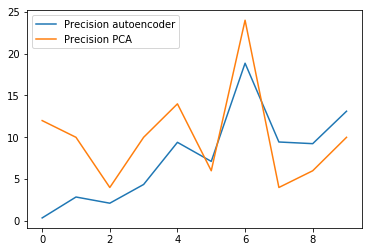

In [189]:
#Plot average recalls for ae with 2 hidden units and pca with 2 hidden units for each digit

plt.plot(range(10), precision_ae)
plt.plot(range(10), precision_pca)
plt.legend(['Precision autoencoder', 'Precision PCA'], loc='upper left')
plt.show()

### Q3. Word2Vec

In [130]:
with open('vectors_new.txt', 'r') as f:
    data = f.readlines()

In [131]:
word_vectors = np.zeros((20000, 50))

In [132]:
word2idx = {}
for i, line in enumerate(data):
    word = line.split(' ')[0]
    wv = line.split(' ')[1:]
    word2idx[word] = i
    for j, dim in enumerate(wv):
        word_vectors[i, j] = float(dim.strip('\n'))

idx2word = {}
for word, idx in word2idx.items():
    idx2word[idx] = word

In [149]:
def get_most_similar(word):
    wv = word_vectors[word2idx[word],:]
    distances = np.sqrt(np.sum((word_vectors - wv)*(word_vectors - wv), axis=1))
    sim_ordered = np.argsort(distances)
    top20 = sim_ordered[:20]
    return list(map(lambda x: idx2word[x], top20.tolist()))

In [153]:
life = get_most_similar('life')
market = get_most_similar('market')
stanford = get_most_similar('stanford')
trump = get_most_similar('trump')
public = get_most_similar('public')
print("Life: {}\n".format(life))
print("Market: {}\n".format(market))
print("Stanford: {}\n".format(stanford))
print("Trump: {}\n".format(trump))
print("Public: {}\n".format(public))



Life: ['life', 'mind', 'lives', 'own', 'kind', 'perhaps', 'experience', 'love', 'indeed', 'whose', 'fact', 'once', 'true', 'seeing', 'finds', 'actually', 'brought', 'same', 'sort', 'goes']

Market: ['market', 'markets', 'stock', 'prices', 'buying', 'consumer', 'retail', 'price', 'trend', 'business', 'rise', 'industry', 'sales', 'sector', 'demand', 'trading', 'higher', 'domestic', 'stocks', 'interest']

Stanford: ['stanford', 'yale', 'ucla', 'princeton', 'harvard', 'rutgers', 'georgetown', 'baylor', 'cornell', 'hopkins', 'penn', 'berkeley', 'vanderbilt', 'uc', 'usc', 'sloan', 'syracuse', 'mason', 'graduate', 'johns']

Trump: ['trump', 'hilton', 'mogul', 'casino', 'vegas', 'murdoch', 'marquee', 'rockefeller', 'carlton', 'overlook', 'rumored', 'jewel', 'daley', 'limelight', 'casinos', 'taj', 'pitt', 'branson', 'billed', 'livingstone']

Public: ['public', 'private', 'office', 'attention', 'for', 'concerned', 'focused', 'address', 'new', 'own', 'calls', 'giving', 'raised', 'provided', 'addi

In [155]:
from sklearn.manifold import TSNE
TSNEmodel = TSNE(n_components=2, random_state=0)

In [156]:
t = TSNEmodel.fit_transform(word_vectors)

In [157]:
np.save('tsne_embeddings', t)

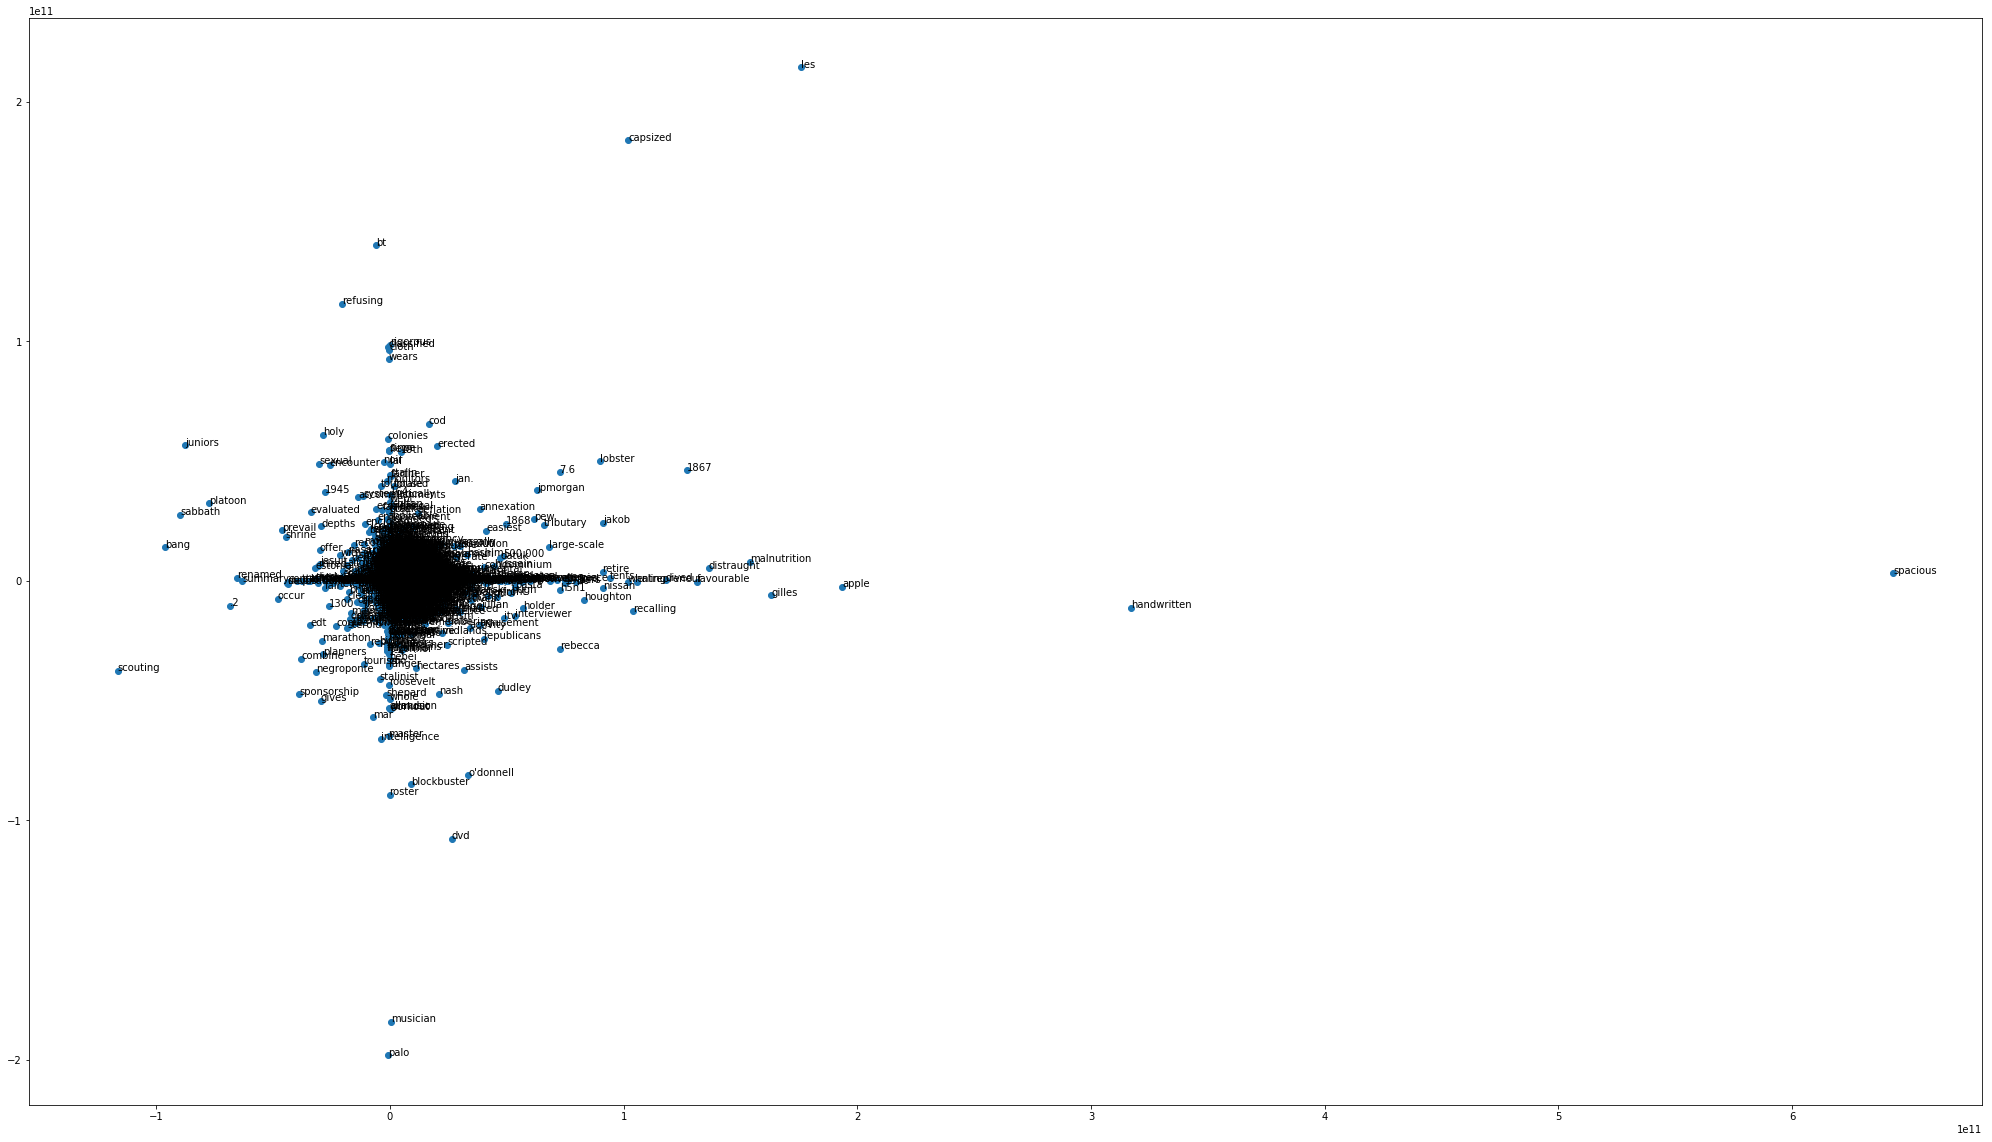

<bound method Figure.savefig of <matplotlib.figure.Figure object at 0x134871da0>>

In [163]:
fig, ax = plt.subplots(figsize=(35,20))
ax.scatter(t[:,0], t[:,1])
for i, data in enumerate(t):
    ax.annotate(idx2word[i], (data[0], data[1]))

plt.show()



In [164]:
fig.savefig('visualization.png')

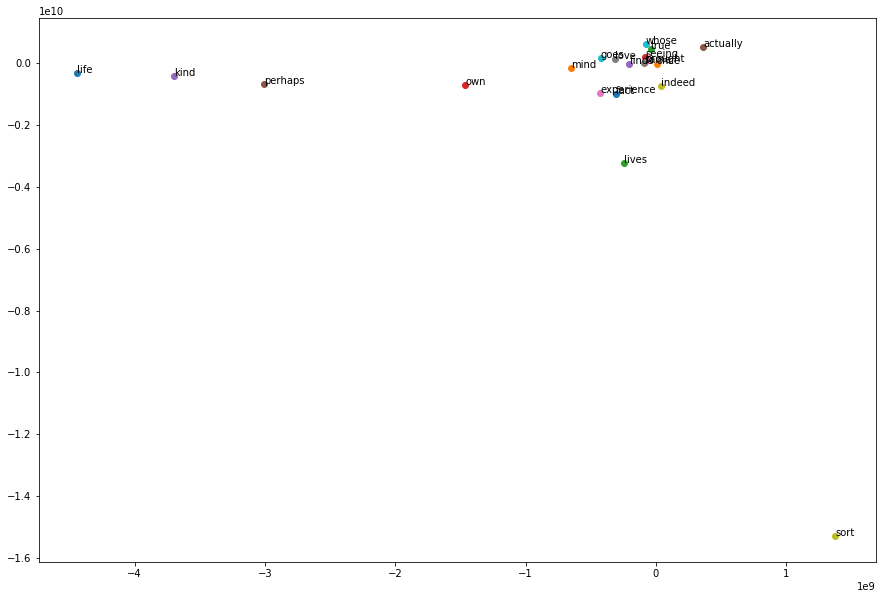

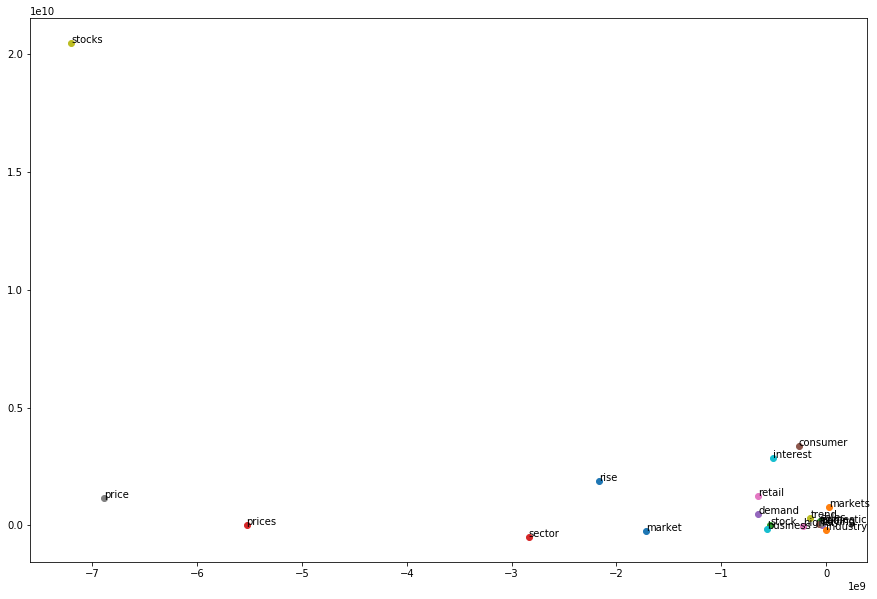

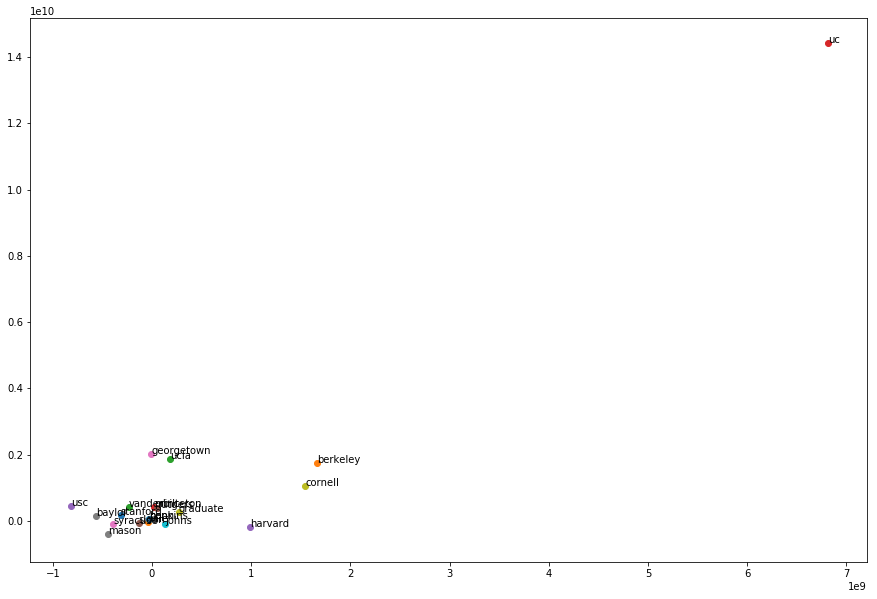

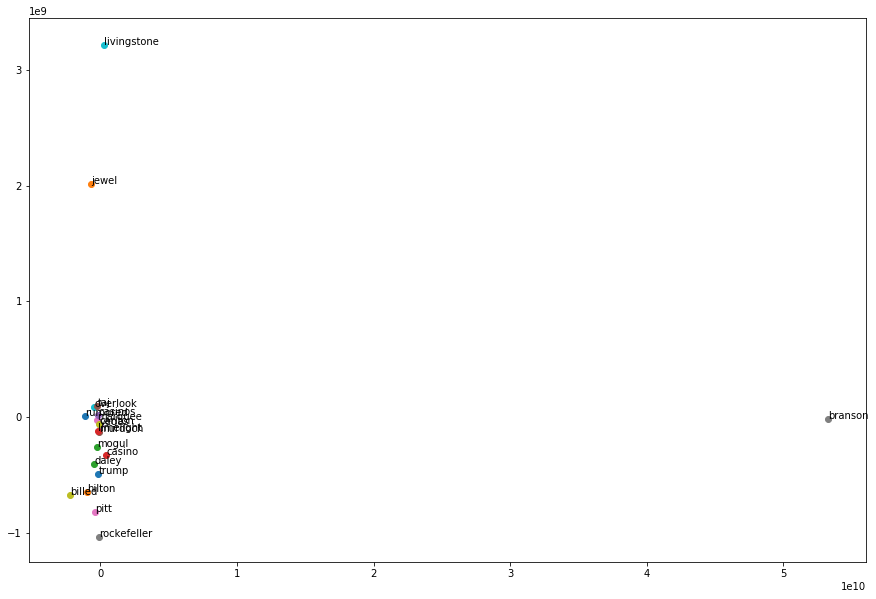

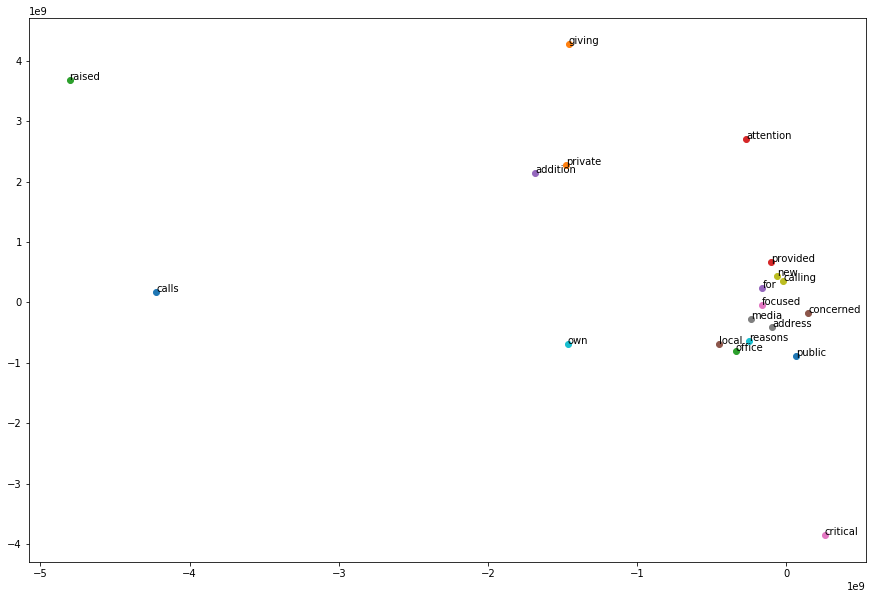

In [171]:
# 'Life'
fig, ax = plt.subplots(figsize=(15,10))
for w in life:
    ax.scatter(t[word2idx[w],0], t[word2idx[w],1])

for w in life:
    ax.annotate(w, (t[word2idx[w],0], t[word2idx[w],1]))
plt.show()
fig.savefig('life.png')

# Market
fig, ax = plt.subplots(figsize=(15,10))
for w in market:
    ax.scatter(t[word2idx[w],0], t[word2idx[w],1])

for w in market:
    ax.annotate(w, (t[word2idx[w],0], t[word2idx[w],1]))
plt.show()
fig.savefig('market.png')


#Stanford
fig, ax = plt.subplots(figsize=(15,10))
for w in stanford:
    ax.scatter(t[word2idx[w],0], t[word2idx[w],1])

for w in stanford:
    ax.annotate(w, (t[word2idx[w],0], t[word2idx[w],1]))
plt.show()
fig.savefig('stanford.png')


#Trump
fig, ax = plt.subplots(figsize=(15,10))
for w in trump:
    ax.scatter(t[word2idx[w],0], t[word2idx[w],1])

for w in trump:
    ax.annotate(w, (t[word2idx[w],0], t[word2idx[w],1]))
plt.show()
fig.savefig('trump.png')


#Public
fig, ax = plt.subplots(figsize=(15,10))
for w in public:
    ax.scatter(t[word2idx[w],0], t[word2idx[w],1])

for w in public:
    ax.annotate(w, (t[word2idx[w],0], t[word2idx[w],1]))
plt.show()
fig.savefig('public.png')
